# **Armonización de Escalas Clínicas: NMSS a MDS-NMS**

En la investigación longitudinal de la Enfermedad de Parkinson, la evolución de los instrumentos de medición presenta un desafío para la continuidad de los datos. Históricamente, la Non-Motor Symptoms Scale (NMSS) ha sido el estándar para evaluar la carga de síntomas no motores. Sin embargo, la reciente introducción de la MDS-Non-Motor Rating Scale (MDS-NMS) requiere establecer una correspondencia lógica entre ambas herramientas para permitir análisis comparativos.

**Objetivo del Mapeo**
Este módulo tiene como finalidad transformar o agrupar los datos recolectados originalmente con la escala NMSS para que sean comparables con los dominios de la nueva escala MDS-NMS. Aunque las escalas difieren en granularidad y estructura temporal, existe un solapamiento conceptual significativo que permite una "traducción" de dominios.

# **Estrategia Metodológica: Abordaje Triangulado**

Para garantizar la robustez de la armonización, este flujo de trabajo implementa tres métodos estadísticos complementarios, ordenados por nivel de complejidad:

**Normalización Porcentual (Linear Scaling)**:
Enfoque: Transforma los puntajes brutos de ambas escalas a un rango común de 0 a 100%.Uso: Permite una comparación absoluta de la "saturación" de síntomas (ej. ¿Qué porcentaje del puntaje máximo posible obtuvo el paciente?).

**Estandarización Z-Score (Distributional Scaling)**:
Enfoque: Convierte los puntajes en desviaciones estándar respecto a la media de la población ($\mu=0, \sigma=1$).Uso: Elimina el sesgo de dificultad de las escalas y permite comparar la posición relativa del paciente frente a su grupo en ambos instrumentos.

**Vinculación Equipercentil (Equipercentile Linking):**
Enfoque: Técnica no paramétrica que mapea puntuaciones buscando rangos de percentiles equivalentes (ej. un score de 20 en NMSS equivale al score en MDS-NMS que esté en el mismo percentil).Uso: Es el método más sofisticado ("Gold Standard" en psicometría) para traducir puntuaciones cuando las distribuciones no son lineales.

**Tabla de Correspondencia (Mapping Logic)**
A continuación se detalla la lógica de agrupación utilizada para alinear los 9 dominios de la NMSS con las secciones correspondientes de la MDS-NMS, basada en la similitud de los constructos clínicos evaluados:

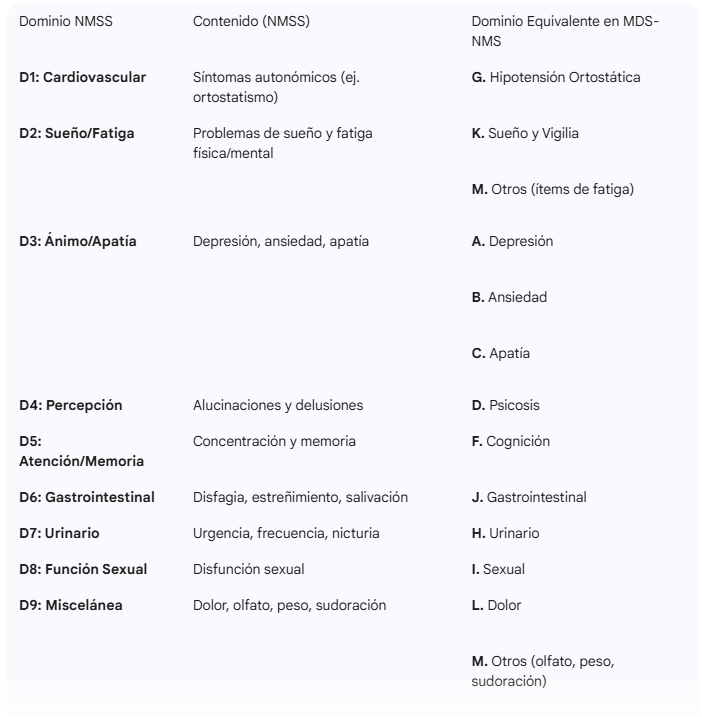

**Nota Metodológica:** Este mapeo es una aproximación conceptual. La escala MDS-NMS incluye ítems adicionales y desgloses más finos (como la fluctuación de síntomas "ON/OFF") que no están presentes en la NMSS original. Por tanto, esta conversión es unidireccional (de menor a mayor complejidad) y agrupa puntuaciones para análisis de tendencias generales.

# **Conexión con Google Drive**

Para comenzar nuestro flujo de trabajo en Google Colab, es necesario establecer una conexión con nuestro sistema de almacenamiento en la nube (Google Drive). Esto nos permitirá leer datasets, guardar modelos y persistir resultados más allá de la sesión actual.

**Montar la unidad (Mounting the Drive)**
El siguiente código importa la librería necesaria y ejecuta el comando de montaje. Al ejecutar esta celda, se solicitará una autorización para acceder a los archivos de tu Drive.

In [1]:
from google.colab import drive

# Monta Google Drive en el directorio /content/drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Configuración del Entorno de Análisis**

Para ejecutar la armonización entre las escalas NMSS y MDS-NMS, primero debemos establecer nuestro entorno de trabajo en Python. Este paso importa las librerías fundamentales que nos permitirán manipular las estructuras de datos, realizar cálculos numéricos para la reagrupación de dominios y visualizar la distribución de los puntajes resultantes.

**Importación de Librerías**
El siguiente bloque de código carga los paquetes estándar de ciencia de datos:

In [2]:
# Data manipulation and numerical computations
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

**Desglose de Herramientas:**
Manipulación y Cálculo (pandas, numpy):

**pandas:** Será el motor principal. Lo usaremos para cargar la base de datos de la NMSS y crear las nuevas columnas correspondientes a la MDS-NMS aplicando la lógica de mapeo (ej. sumar ítems específicos para crear un nuevo dominio).

**numpy:** Nos ayudará en operaciones vectorizadas, esencial si necesitamos normalizar puntajes o manejar valores nulos durante la conversión.

**Visualización (matplotlib, seaborn):**

Estas librerías son cruciales para la etapa de validación. Una vez realizado el mapeo, necesitaremos graficar las distribuciones para asegurar que la transformación de datos no haya generado sesgos o anomalías estadísticas inesperadas.

# **Carga e Inspección del Dataset**

Una vez importadas las librerías y montada la unidad de almacenamiento, procedemos a cargar los datos fuente para el análisis. En este caso, trabajaremos con un archivo Excel (.xlsx) ubicado en una ruta específica del proyecto ReMePARK.

**Lectura del archivo Excel**
El siguiente bloque define la ruta absoluta del archivo dentro de Google Drive, lo carga en memoria como un objeto DataFrame de Pandas y muestra una vista previa inicial.

In [ ]:
# Definir ruta del archivo fuente
file_path = '/content/drive/MyDrive/LCEN/08_Bases de Datos y Herramientas/08.2_ReMePARK/08.2.6_Unified ReMePARK 2024/Remepark_NMSS_MDSNMS.xlsx'

# Cargar archivo Excel en un DataFrame
df = pd.read_excel(file_path)

# Visualizar las primeras 5 filas para verificar la carga correcta
df.head()

# **Definición de Dominios y Normalización de Puntajes**

Dado que la escala **NMSS y la MDS-NMS** tienen diferentes números de ítems y rangos de puntuación total, no es posible comparar sus puntajes brutos (raw scores) directamente. Para resolver esto, implementamos un proceso de **normalización porcentual**.

Convertimos los puntajes de cada dominio a una escala estándar de 0 a 100, donde:

**0%: **Ausencia total de síntomas en ese dominio.

**100%: **Máxima severidad y frecuencia posible en todos los ítems del dominio.

**Configuración de Metadatos**
Primero, definimos la estructura de cada instrumento mediante diccionarios. Esto mapea qué columnas de la base de datos pertenecen a qué dominio clínico y cuántos ítems lo componen.

**Parámetro Clave:** MAX_ITEM_SCORE = 16. Esto deriva de la multiplicación de la Frecuencia máxima (4) por la Severidad máxima (4) en cada ítem individual.

In [ ]:
# Nota: Asumimos que 'df' ya está cargado previamente.
# Si no, descomentar: df = pd.read_csv('your_data.csv')

# Puntaje máximo posible por ítem individual (Frecuencia 4 * Severidad 4)
MAX_ITEM_SCORE = 16

# --- Mapeo de Dominios NMSS ---
# Estructura: Nombre del Dominio -> Columnas involucradas y cantidad de preguntas
nmss_domains = {
    "NMSS_Mood": {
        "columns": ["nms13total", "nms14total", "nmstotal15"],
        "n_items": 3
    },
    "NMSS_Perceptual": {
        "columns": ["nmss16total", "nmss17total", "nmss18total"],
        "n_items": 3
    },
    # ... (Se definen el resto de dominios: Atención, Gastro, Urinario, Sexual, Miscelánea)
    # Nota: Asegurar que los nombres de columnas coincidan exactamente con el CSV
}

# --- Mapeo de Dominios MDS-NMS ---
# En este caso, asumimos que la base de datos ya tiene los subtotales por dominio calculados
mds_domains = {
    "MDS_NMS_A": {"columns": ["NMS.A.TOTAL"], "n_items": 5}, # Depresión
    "MDS_NMS_B": {"columns": ["NMS.B.TOTAL"], "n_items": 4}, # Ansiedad
    "MDS_NMS_C": {"columns": ["NMS.C.TOTAL"], "n_items": 3}, # Apatía
    "MDS_NMS_D": {"columns": ["NMS.D.TOTAL"], "n_items": 4}, # Psicosis
    # ... (Se definen el resto de dominios hasta la letra M)
}

# **Función de Normalización**

A continuación, implementamos la función normalize_domain_score. Esta función automatiza el cálculo para cualquier diccionario de dominios que le pasemos.
Fórmula Matemática aplicada:

$$\text{Score Normalizado} = \left( \frac{\text{Puntaje Bruto del Dominio}}{\text{Nº Ítems} \times 16} \right) \times 100$$

In [ ]:
def normalize_domain_score(df, domain_mapping, domain_name_prefix="norm_"):
    """
    Calcula el puntaje normalizado (0-100%) para cada dominio y lo agrega al DataFrame.

    Args:
      df (pd.DataFrame): DataFrame con los puntajes brutos.
      domain_mapping (dict): Diccionario con la configuración de dominios (columnas e ítems).
      domain_name_prefix (str): Prefijo para las nuevas columnas (ej. 'norm_NMSS_').

    Returns:
      pd.DataFrame: El mismo DataFrame con las nuevas columnas agregadas.
    """
    for domain, info in domain_mapping.items():
        cols = info["columns"]
        n_items = info["n_items"]

        # 1. Obtener puntaje bruto (suma de columnas si es necesario)
        raw_score = df[cols].sum(axis=1)

        # 2. Calcular el denominador (Techo máximo posible del dominio)
        max_possible = n_items * MAX_ITEM_SCORE

        # 3. Calcular porcentaje
        norm_score = (raw_score / max_possible) * 100

        # 4. Guardar en nueva columna
        new_col = f"{domain_name_prefix}{domain}"
        df[new_col] = norm_score

    return df

# **Ejecución del Proceso**

Finalmente, aplicamos la función a ambas escalas para generar las variables comparables.

In [ ]:
# 1. Normalizar escala antigua (NMSS)
# Prefijo resultante ejemplo: 'norm_NMSS_Mood'
df = normalize_domain_score(df, nmss_domains, domain_name_prefix="norm_")

# 2. Normalizar escala nueva (MDS-NMS)
# Prefijo resultante ejemplo: 'norm_MDS_NMS_A'
df = normalize_domain_score(df, mds_domains, domain_name_prefix="norm_")

# Verificación de las nuevas columnas creadas
print("Nuevas columnas generadas (Vista previa):")
print(df.filter(like="norm_").head())

# **Visualización y Validación Convergente**

Una vez normalizados los puntajes, el siguiente paso es validar la consistencia del mapeo. Utilizaremos dos herramientas gráficas principales:

Mapa de Calor (Heatmap): Para ver la correlación global entre todos los dominios.

Gráficos de Dispersión (Scatter Plots): Para inspeccionar la relación lineal detallada entre pares específicos de dominios.

**A. Matriz de Correlación (Heatmap)**

Este gráfico nos permitirá identificar rápidamente patrones "calientes" (colores oscuros) donde existe una fuerte asociación entre la escala antigua (NMSS) y la nueva (MDS-NMS).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Identificar las columnas normalizadas
cols_nmss = [col for col in df.columns if "norm_NMSS" in col]
cols_mds = [col for col in df.columns if "norm_MDS_NMS" in col]

# 2. Calcular la matriz de correlación (Método Spearman para datos no normales)
# Calculamos la correlación solo entre las dos escalas (no intra-escala)
corr_matrix = df[cols_nmss + cols_mds].corr(method='spearman')

# Filtramos para mostrar solo NMSS (filas) vs MDS-NMS (columnas) para mayor claridad
corr_target = corr_matrix.loc[cols_nmss, cols_mds]

# 3. Generar el Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_target,
            annot=True,       # Mostrar el valor numérico
            fmt=".2f",        # 2 decimales
            cmap="RdBu_r",    # Escala de color (Rojo=Alto, Azul=Bajo)
            center=0,         # Centrar la escala en 0
            linewidths=0.5)

plt.title("Matriz de Correlación: NMSS vs MDS-NMS (Dominios Normalizados)", fontsize=16)
plt.ylabel("Dominios NMSS (Originales)", fontsize=12)
plt.xlabel("Dominios MDS-NMS (Nuevos)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Interpretación esperada:**

Deberías ver correlaciones altas (>0.5) en las intersecciones lógicas descritas en nuestra tabla inicial (ej. NMSS_Mood cruzado con MDS_NMS_A_Depression).

Si ves una correlación baja en un cruce esperado, indica que las escalas podrían estar midiendo matices diferentes del síntoma.

# **B. Análisis Detallado (Scatter Plots)**

Para profundizar, podemos graficar pares específicos. Esto ayuda a detectar "efectos techo" o "efectos suelo" (donde una escala marca 0 pero la otra marca síntomas).

In [ ]:
def plot_domain_comparison(df, col_nmss, col_mds, title_suffix=""):
    """Genera un scatter plot con línea de regresión para comparar dos dominios."""
    plt.figure(figsize=(8, 6))

    # Gráfico de dispersión con regresión lineal
    sns.regplot(data=df, x=col_nmss, y=col_mds,
                scatter_kws={'alpha':0.5, 'color': 'teal'},
                line_kws={'color': 'darkred'})

    plt.title(f"Comparación Directa: {title_suffix}", fontsize=14)
    plt.xlabel(f"{col_nmss} (0-100%)", fontsize=12)
    plt.ylabel(f"{col_mds} (0-100%)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Ejemplo de uso: Comparar 'Mood' (NMSS) con 'Depression' (MDS-NMS)
# Ajusta los nombres de las columnas según tus resultados exactos
if 'norm_NMSS_Mood' in df.columns and 'norm_MDS_NMS_MDS_NMS_A' in df.columns:
    plot_domain_comparison(df,
                           'norm_NMSS_Mood',
                           'norm_MDS_NMS_MDS_NMS_A',
                           title_suffix="Ánimo vs Depresión")

# **Estandarización Estadística (Z-score Transformation)**

Además de la normalización porcentual, una técnica estándar en psicometría para comparar escalas con métricas diferentes es la **Transformación Z (Z-score)**.

Este método re-escala los datos para que tengan una m**edia ($\mu$) de 0 y una desviación estándar ($\sigma$) de 1**.

A diferencia del porcentaje (que es absoluto), el Z-score es relativo a la población: nos dice cuántas desviaciones estándar se aleja un paciente del promedio del grupo.

**Fórmula Matemática**

Para cada dominio $d$ y paciente $i$, el puntaje Z se calcula como:$$Z_{i,d} = \frac{X_{i,d} - \mu_d}{\sigma_d}$$

Donde:$X_{i,d}$: Puntaje bruto del paciente en el dominio.$\mu_d$:

Promedio (media) del dominio en toda la muestra.$\sigma_d$:
Desviación estándar del dominio en la muestra.

**Implementación del Código**

El siguiente bloque define los dominios y aplica la función de estandarización. Si un dominio tiene una desviación estándar de 0 (todos los pacientes tienen el mismo puntaje), el código asigna 0 para evitar errores matemáticos.

In [ ]:
# Definición de Mapeos (Si no se definieron previamente)
# NMSS: Estructura original
nmss_domains = {
    "NMSS_Mood": {"columns": ["nms13total", "nms14total", "nmstotal15"], "n_items": 3},
    "NMSS_Perceptual": {"columns": ["nmss16total", "nmss17total", "nmss18total"], "n_items": 3},
    "NMSS_Attention": {"columns": ["nms19total", "nms20total", "nmstotal21"], "n_items": 3},
    "NMSS_Gastro": {"columns": ["nms22total", "nms23total", "nms24total"], "n_items": 3},
    "NMSS_Urinary": {"columns": ["nms25total", "nms26total"], "n_items": 2},
    "NMSS_Sexual": {"columns": ["nmstotal27", "nmstotal28", "nmstotal29", "nmstotal30"], "n_items": 4},
    "NMSS_Misc": {"columns": ["nmstotal"], "n_items": 1}
}

# MDS-NMS: Estructura nueva (asumiendo columnas de totales ya calculadas)
mds_domains = {
    "MDS_NMS_A": {"columns": ["NMS.A.TOTAL"], "n_items": 5},
    "MDS_NMS_B": {"columns": ["NMS.B.TOTAL"], "n_items": 4},
    "MDS_NMS_C": {"columns": ["NMS.C.TOTAL"], "n_items": 3},
    "MDS_NMS_D": {"columns": ["NMS.D.TOTAL"], "n_items": 4},
    "MDS_NMS_E": {"columns": ["NMS.E.TOTAL"], "n_items": 4},
    "MDS_NMS_F": {"columns": ["NMS.F.TOTAL"], "n_items": 6},
    "MDS_NMS_G": {"columns": ["NMS.G.TOTAL"], "n_items": 2},
    "MDS_NMS_H": {"columns": ["NMS.H.TOTAL"], "n_items": 3},
    "MDS_NMS_I": {"columns": ["NMS.I.TOTAL"], "n_items": 2},
    "MDS_NMS_J": {"columns": ["NMS.J.TOTAL"], "n_items": 4},
    "MDS_NMS_K": {"columns": ["NMS.K.TOTAL"], "n_items": 6},
    "MDS_NMS_L": {"columns": ["NMS.L.TOTAL"], "n_items": 4},
    "MDS_NMS_M": {"columns": ["NMS.M.TOTAL"], "n_items": 5}
}

def compute_z_scores(df, domain_mapping, domain_name_prefix="z_"):
    """
    Calcula el Z-score para cada dominio basado en la media y desviación estándar de la muestra actual.

    Args:
        df: DataFrame con puntajes brutos.
        domain_mapping: Diccionario de configuración de dominios.
        domain_name_prefix: Prefijo para las nuevas columnas (ej. 'z_NMSS_').
    """
    for domain, info in domain_mapping.items():
        cols = info["columns"]

        # 1. Calcular puntaje bruto total del dominio
        raw_score = df[cols].sum(axis=1)

        # 2. Obtener estadísticas de la muestra (Calibración)
        mean_score = raw_score.mean()
        std_score = raw_score.std()

        # 3. Aplicar fórmula Z-score
        # Manejo de excepción: Si std es 0, el Z-score es 0 (evita división por cero)
        if std_score != 0:
            z_score = (raw_score - mean_score) / std_score
        else:
            z_score = 0

        # 4. Guardar columna
        new_col = f"{domain_name_prefix}{domain}"
        df[new_col] = z_score

    return df

# Ejecución de la transformación
# Genera columnas como: 'z_NMSS_Mood', 'z_MDS_NMS_A', etc.
df = compute_z_scores(df, nmss_domains, domain_name_prefix="z_NMSS_")
df = compute_z_scores(df, mds_domains, domain_name_prefix="z_MDS_NMS_")

# Verificación
print("Vista previa de puntajes Z:")
print(df.filter(like="z_").head())

**Interpretación Clínica de los Resultados**

Al analizar las nuevas columnas z_..., la interpretación es la siguiente:

**Z = 0:** El paciente tiene una severidad de síntomas exactamente en el promedio de la población estudiada.

**Z = +1.0:** El paciente tiene síntomas más severos que el promedio (está a 1 desviación estándar por encima).

**Z = -1.0:** El paciente tiene síntomas menos severos que el promedio.

**Z > +2.0:** Indica una severidad clínica inusualmente alta (valores atípicos o outliers).

**Ventaja sobre la Normalización Porcentual**:

Si la Escala A es muy difícil y casi todos sacan puntajes bajos, y la Escala B es fácil y todos sacan puntajes altos, la normalización porcentual no corrige ese sesgo de dificultad. El Z-score sí lo hace, alineando las "curvas de campana" de ambas escalas una sobre la otra.

# **Visualización de la Armonización (Z-Scores)**

Una vez estandarizados los datos, es fundamental verificar visualmente la alineación entre la escala antigua (NMSS) y la nueva (MDS-NMS). Dado que los Z-scores eliminan las diferencias de unidades y rangos, podemos superponer las distribuciones directamente.

**Estrategia de Visualización**

Utilizaremos dos tipos de gráficos complementarios:

**Gráfico de Densidad (KDE Plot):** Nos muestra la "forma" de los datos. Si la armonización es correcta, las campanas de ambas escalas deberían tener cimas y anchos similares.

**Diagrama de Caja (Boxplot):** Nos permite comparar medianas y detectar valores atípicos (outliers) lado a lado.

**Código de Generación de Gráficos**

Para facilitar la visualización con seaborn, primero transformamos los datos a un formato "largo" (long format) y luego graficamos.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_zscore_comparison(df):
    """
    Genera gráficos comparativos para visualizar la distribución de los Z-scores
    entre dominios equivalentes de NMSS y MDS-NMS.
    """
    # 1. Filtrar solo las columnas de Z-score
    z_cols = [col for col in df.columns if col.startswith("z_")]

    # Si no hay columnas Z, salir
    if not z_cols:
        print("⚠️ No se encontraron columnas de Z-score.")
        return

    # 2. Transformar a formato largo para Seaborn (Melt)
    # Esto crea una tabla con dos columnas: 'Variable' (Nombre del dominio) y 'Value' (Z-score)
    df_long = df[z_cols].melt(var_name="Dominio", value_name="Z-Score")

    # Crear una columna auxiliar para distinguir 'Tipo de Escala' (NMSS vs MDS-NMS)
    # Si el nombre contiene 'NMSS', es la escala vieja; si no, la nueva.
    df_long["Escala"] = df_long["Dominio"].apply(lambda x: "NMSS (Original)" if "NMSS" in x else "MDS-NMS (Nueva)")

    # -------------------------------------------------------
    # Gráfico A: Distribución de Densidad (KDE)
    # -------------------------------------------------------
    plt.figure(figsize=(10, 6))

    # Dibujamos las curvas de densidad separadas por color de escala
    sns.kdeplot(data=df_long, x="Z-Score", hue="Escala",
                fill=True, alpha=0.3, linewidth=2, palette="viridis")

    plt.title("Comparación Global de Distribuciones Z-Score", fontsize=16)
    plt.xlabel("Desviaciones Estándar (Z-Score)", fontsize=12)
    plt.ylabel("Densidad", fontsize=12)
    plt.axvline(0, color='black', linestyle='--', alpha=0.5, label="Media Poblacional (0)")
    plt.legend(title="Instrumento")
    plt.grid(axis='x', alpha=0.3)
    plt.show()

    # -------------------------------------------------------
    # Gráfico B: Boxplot Detallado por Dominio
    # -------------------------------------------------------
    # Este gráfico puede ser muy grande si hay muchos dominios, ajustamos el tamaño
    plt.figure(figsize=(14, 8))

    sns.boxplot(data=df_long, x="Dominio", y="Z-Score", hue="Escala",
                palette="coolwarm", showfliers=False) # showfliers=False oculta outliers extremos para ver mejor las cajas

    plt.title("Distribución de Z-Scores por Dominio Específico", fontsize=16)
    plt.xticks(rotation=90) # Rotar etiquetas para que se lean bien
    plt.ylabel("Z-Score", fontsize=12)
    plt.xlabel("Dominios", fontsize=12)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

# Ejecutar la función
plot_zscore_comparison(df)

**Guía de Interpretación**

**En el Gráfico de Densidad (KDE):**

**Éxito:** Las dos curvas (azul y verde, por ejemplo) se superponen casi perfectamente, formando una campana centrada en 0.

**Desviación**: Si una curva está desplazada a la derecha (ej. centrada en +1), significa que esa escala tiende a reportar síntomas más severos sistemáticamente que la otra.

**En el Boxplot:**

Observa las líneas centrales dentro de las cajas (la mediana). Deberían estar todas cerca de la línea punteada del 0.

Si ves un dominio específico donde la caja de NMSS es muy diferente a la de MDS-NMS, ese dominio requiere revisión clínica (quizás las preguntas no son tan equivalentes como pensábamos).

# **Vinculación Equipercentil (Equipercentile Linking or Item Response Theory (IRT))**

Finalmente, implementamos la técnica de Equipercentile Linking. A diferencia de la normalización lineal o los Z-scores (que asumen distribuciones similares), este método es no paramétrico y robusto ante distribuciones asimétricas.

**¿Cuál es la lógica? **
Si un paciente tiene una puntuación en la escala NMSS que lo coloca en el percentil 80 (es decir, sus síntomas son más severos que el 80% de la población), buscamos qué puntuación en la escala MDS-NMS corresponde exactamente a ese mismo percentil 80. De esta forma, alineamos los rangos de severidad clínica en lugar de los números crudos.

**Definición de la Función de Vinculación**

El siguiente código crea una función dinámica que aprende la relación entre dos distribuciones (Calibración) y devuelve una herramienta para transformar nuevos puntajes.

In [ ]:
import numpy as np
import pandas as pd

def create_linking_function(calib_df, scale_A_col, scale_B_col):
    """
    Crea una función de vinculación equipercentil entre dos escalas utilizando una muestra de calibración.

    Parámetros:
      calib_df (pd.DataFrame): DataFrame que contiene los puntajes de ambas escalas (Muestra de doble aplicación).
      scale_A_col (str): Nombre de la columna de la Escala A (Origen, ej. NMSS).
      scale_B_col (str): Nombre de la columna de la Escala B (Destino, ej. MDS-NMS).

    Retorna:
      link_func (function): Una función ejecutable que toma un puntaje de A y devuelve su equivalente en B.
    """
    # 1. Extraer y ordenar los arrays de puntajes de la muestra de calibración.
    # Es vital eliminar NaNs antes de ordenar para no romper la interpolación.
    scores_A = np.sort(calib_df[scale_A_col].dropna().values)
    scores_B = np.sort(calib_df[scale_B_col].dropna().values)

    # 2. Crear una referencia de percentiles (0 a 100) basada en el tamaño de la muestra A.
    percentiles = np.linspace(0, 100, len(scores_A))

    # 3. Definir la función interna (Closure) que realizará la conversión futura.
    def link_func(new_score):
        # Paso A: Encontrar en qué percentil cae el 'new_score' dentro de la distribución original (A).
        # np.interp realiza una interpolación lineal si el valor cae entre dos puntos observados.
        perc = np.interp(new_score, scores_A, percentiles)

        # Paso B: Buscar qué puntaje en la distribución destino (B) corresponde a ese percentil calculado.
        linked_score = np.percentile(scores_B, perc)

        return linked_score

    return link_func

**Ejemplo de Aplicación Práctica**

Imagina que queremos traducir el puntaje del dominio "Ánimo" de la escala vieja a la nueva. Usamos el DataFrame df que ya hemos procesado como nuestra muestra de calibración.

In [ ]:
# --- Configuración del Ejemplo ---
# Supongamos que nuestras columnas de totales brutos (Raw Scores) son:
col_origen = "nms13total"      # Ítem o total de dominio NMSS
col_destino = "NMS.A.TOTAL"    # Total de dominio MDS-NMS

# 1. Entrenar el vinculador (Aprender la relación entre distribuciones)
link_fn_mood = create_linking_function(df, col_origen, col_destino)

# 2. Probar la conversión con un puntaje nuevo
new_nmss_score = 20  # Un paciente con puntaje 20 en NMSS
linked_score = link_fn_mood(new_nmss_score)

print(f"--- Resultado del Equipercentile Linking ---")
print(f"Puntaje original (NMSS): {new_nmss_score}")
print(f"Equivalente armonizado (MDS-NMS): {linked_score:.2f}")

# 3. Aplicar a toda una columna (Opcional)
# df['NMSS_to_MDS_Linked'] = df[col_origen].apply(link_fn_mood)

**Nota Metodológica:** Este método requiere una muestra de **"doble aplicación"** (pacientes a los que se les aplicaron ambas escalas). Si tu base de datos actual contiene respuestas para ambos instrumentos en los mismos sujetos, es el escenario ideal para usar esta función.